In [119]:
import sys
sys.path.append("..")

import os
import copy
import torch
from TTS.utils.audio import AudioProcessor
from TTS.utils.manage import ModelManager
from TTS.config import load_config
from TTS.tts.models import setup_model as setup_tts_model
from TTS.vocoder.models import setup_model as setup_vocoder_model
from TTS.vocoder.utils.generic_utils import interpolate_vocoder_input

from TTS.tts.models.tacotron2 import Tacotron2
from TTS.tts.configs.tacotron2_config import Tacotron2Config
from TTS.tts.utils.text.tokenizer import TTSTokenizer
from TTS.tts.utils.speakers import SpeakerManager
from TTS.utils.audio import AudioProcessor

from cl_tts.utils.plot_utils import plot_spectrogram


In [134]:
model_manager = ModelManager(output_prefix="../data/pretrained_models/")

# TTS Model
checkpoint_path_tts, config_path_tts, model_item_tts  = model_manager.download_model("tts_models/en/ljspeech/tacotron2-DCA")
tts_config = load_config(config_path_tts)
tts_model = setup_tts_model(config=tts_config)
tts_model.load_checkpoint(tts_config, checkpoint_path_tts, eval=True)

# Vocoder
checkpoint_path_vocoder, config_path_vocoder, model_item_vocoder  = model_manager.download_model("vocoder_models/universal/libri-tts/fullband-melgan")
vocoder_config = load_config(config_path_vocoder)
vocoder_ap = AudioProcessor(verbose=False, **vocoder_config.audio)
vocoder_model = setup_vocoder_model(vocoder_config)
vocoder_model.load_checkpoint(vocoder_config, checkpoint_path_vocoder, eval=True)


 > tts_models/en/ljspeech/tacotron2-DCA is already downloaded.
 > Using model: Tacotron2
 > Setting up Audio Processor...
 | > sample_rate:22050
 | > resample:False
 | > num_mels:80
 | > log_func:np.log10
 | > min_level_db:-100
 | > frame_shift_ms:None
 | > frame_length_ms:None
 | > ref_level_db:20
 | > fft_size:1024
 | > power:1.5
 | > preemphasis:0.0
 | > griffin_lim_iters:60
 | > signal_norm:True
 | > symmetric_norm:True
 | > mel_fmin:50.0
 | > mel_fmax:7600.0
 | > pitch_fmin:0.0
 | > pitch_fmax:640.0
 | > spec_gain:1.0
 | > stft_pad_mode:reflect
 | > max_norm:4.0
 | > clip_norm:True
 | > do_trim_silence:True
 | > trim_db:60
 | > do_sound_norm:False
 | > do_amp_to_db_linear:True
 | > do_amp_to_db_mel:True
 | > do_rms_norm:False
 | > db_level:None
 | > stats_path:../data/pretrained_models/tts/tts_models--en--ljspeech--tacotron2-DCA/scale_stats.npy
 | > base:10
 | > hop_length:256
 | > win_length:1024
 > Model's reduction rate `r` is set to: 2
 > vocoder_models/universal/libri-tts/ful

In [146]:
params = {"sample_rate": 24000, "resample": True}

ds_path = "/raid/hhemati/Datasets/Speech/CL-TTS/VCTK/"
config = copy.copy(tts_config)

config.text_cleaner = "phoneme_cleaners"
config.use_phonemes = True
config.phoneme_language = "en-us"
config.phoneme_cache_path = os.path.join(ds_path, "phonemes")
config.use_d_vector_file = True
config.d_vector_dim = 256

config.audio = copy.copy(vocoder_config.audio)
config.audio.sample_rate = params["sample_rate"]
config.audio.resample = params["resample"]

ap = AudioProcessor.init_from_config(config)
tokenizer, config = TTSTokenizer.init_from_config(config)
d_vectors_file_path = os.path.join(ds_path, "speaker_embedding_means.json")
speaker_manager = SpeakerManager(d_vectors_file_path=d_vectors_file_path)
model_new = Tacotron2(config, ap, tokenizer, speaker_manager=speaker_manager)

 > Setting up Audio Processor...
 | > sample_rate:24000
 | > resample:True
 | > num_mels:80
 | > log_func:np.log10
 | > min_level_db:-100
 | > frame_shift_ms:None
 | > frame_length_ms:None
 | > ref_level_db:0
 | > fft_size:1024
 | > power:1.5
 | > preemphasis:0.0
 | > griffin_lim_iters:60
 | > signal_norm:True
 | > symmetric_norm:True
 | > mel_fmin:50.0
 | > mel_fmax:7600.0
 | > pitch_fmin:0.0
 | > pitch_fmax:640.0
 | > spec_gain:1.0
 | > stft_pad_mode:reflect
 | > max_norm:4.0
 | > clip_norm:True
 | > do_trim_silence:True
 | > trim_db:60
 | > do_sound_norm:False
 | > do_amp_to_db_linear:True
 | > do_amp_to_db_mel:True
 | > do_rms_norm:False
 | > db_level:None
 | > stats_path:../data/pretrained_models/tts/vocoder_models--universal--libri-tts--fullband-melgan/scale_stats.npy
 | > base:10
 | > hop_length:256
 | > win_length:1024


In [155]:
# Copy weights from the pre-trained model to the new model
print("Copying model weights from a pre-trained model ...")
for (n1, p1), (n2, p2) in zip(model_new.named_parameters(),
                              tts_model.named_parameters()):
    if p1.shape == p2.shape:
        p1.data.copy_(p2.data)
    else:
        print("Could not copy weights for ", n1)


Copying model weights from the pre-trained model ...
Could not copy weights for  decoder.attention_rnn.weight_ih
Could not copy weights for  decoder.decoder_rnn.weight_ih
Could not copy weights for  decoder.linear_projection.linear_layer.weight


In [94]:
tts_model.eval()
text = tts_model.tokenizer.text_to_ids("This is a sample text.")
text = torch.LongTensor(text).unsqueeze(0)

outputs = tts_model.inference(text)
outputs["model_outputs"].shape

torch.Size([1, 132, 80])

 > interpolating tts model output.
 > before interpolation : (80, 132)
 > after interpolation : torch.Size([1, 80, 143])


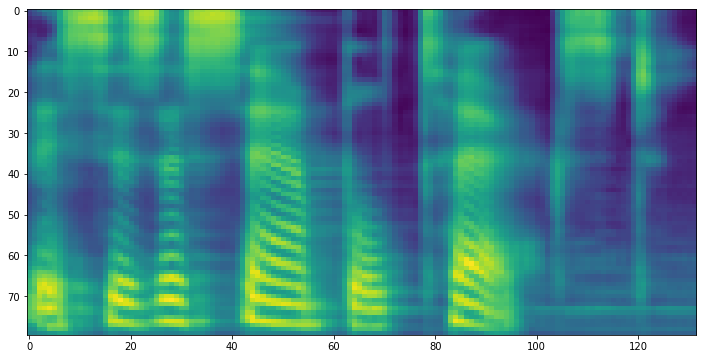

In [105]:
mel_postnet_spec = outputs["model_outputs"][0].detach().cpu().numpy()
mel_postnet_spec = tts_model.ap.denormalize(mel_postnet_spec.T).T
vocoder_input = vocoder_ap.normalize(mel_postnet_spec.T)
scale_factor = [1, vocoder_config["audio"]["sample_rate"] / tts_model.ap.sample_rate,]

if scale_factor[1] != 1:
    print(" > interpolating tts model output.")
    vocoder_input = interpolate_vocoder_input(scale_factor, vocoder_input)
else:
    vocoder_input = torch.tensor(vocoder_input).unsqueeze(0)  # pylint: disable=not-callable

waveform = vocoder_model.inference(vocoder_input)
waveform = waveform.squeeze().numpy()
tts_model.ap.save_wav(waveform, "./out/sample.wav", tts_config.audio.sample_rate)
plot_spectrogram(mel_postnet_spec.T)

In [156]:
mel_postnet_spec.shape

(132, 80)

In [106]:
vocoder_config.audio

BaseAudioConfig(fft_size=1024, win_length=1024, hop_length=256, frame_shift_ms=None, frame_length_ms=None, stft_pad_mode='reflect', sample_rate=24000, resample=False, preemphasis=0.0, ref_level_db=0, do_sound_norm=False, log_func='np.log10', do_trim_silence=True, trim_db=60, do_rms_norm=False, db_level=None, power=1.5, griffin_lim_iters=60, num_mels=80, mel_fmin=50.0, mel_fmax=7600.0, spec_gain=1, do_amp_to_db_linear=True, do_amp_to_db_mel=True, pitch_fmax=640.0, pitch_fmin=0.0, signal_norm=True, min_level_db=-100, symmetric_norm=True, max_norm=4.0, clip_norm=True, stats_path='../data/pretrained_models/tts/vocoder_models--universal--libri-tts--fullband-melgan/scale_stats.npy')

In [90]:
tts_config.audio

BaseAudioConfig(fft_size=1024, win_length=1024, hop_length=256, frame_shift_ms=None, frame_length_ms=None, stft_pad_mode='reflect', sample_rate=22050, resample=False, preemphasis=0.0, ref_level_db=20, do_sound_norm=False, log_func='np.log10', do_trim_silence=True, trim_db=60, do_rms_norm=False, db_level=None, power=1.5, griffin_lim_iters=60, num_mels=80, mel_fmin=50.0, mel_fmax=7600.0, spec_gain=1, do_amp_to_db_linear=True, do_amp_to_db_mel=True, pitch_fmax=640.0, pitch_fmin=0.0, signal_norm=True, min_level_db=-100, symmetric_norm=True, max_norm=4.0, clip_norm=True, stats_path='../data/pretrained_models/tts/tts_models--en--ljspeech--tacotron2-DCA/scale_stats.npy')

BaseAudioConfig(fft_size=1024, win_length=1024, hop_length=256, frame_shift_ms=None, frame_length_ms=None, stft_pad_mode='reflect', sample_rate=22050, resample=False, preemphasis=0.0, ref_level_db=20, do_sound_norm=False, log_func='np.log10', do_trim_silence=True, trim_db=60, do_rms_norm=False, db_level=None, power=1.5, griffin_lim_iters=60, num_mels=80, mel_fmin=50.0, mel_fmax=7600.0, spec_gain=1, do_amp_to_db_linear=True, do_amp_to_db_mel=True, pitch_fmax=640.0, pitch_fmin=0.0, signal_norm=True, min_level_db=-100, symmetric_norm=True, max_norm=4.0, clip_norm=True, stats_path='../data/pretrained_models/tts/tts_models--en--ljspeech--tacotron2-DCA/scale_stats.npy')